Window: 442 samples (20ms)
5167470 5234580
Time: 1.2787302455893574 x realtime
Segments: [(8042, 14106), (15448, 19076), (20346, 30145), (35113, 37145), (38163, 47035), (47617, 56043), (58419, 61341), (62764, 66445)]


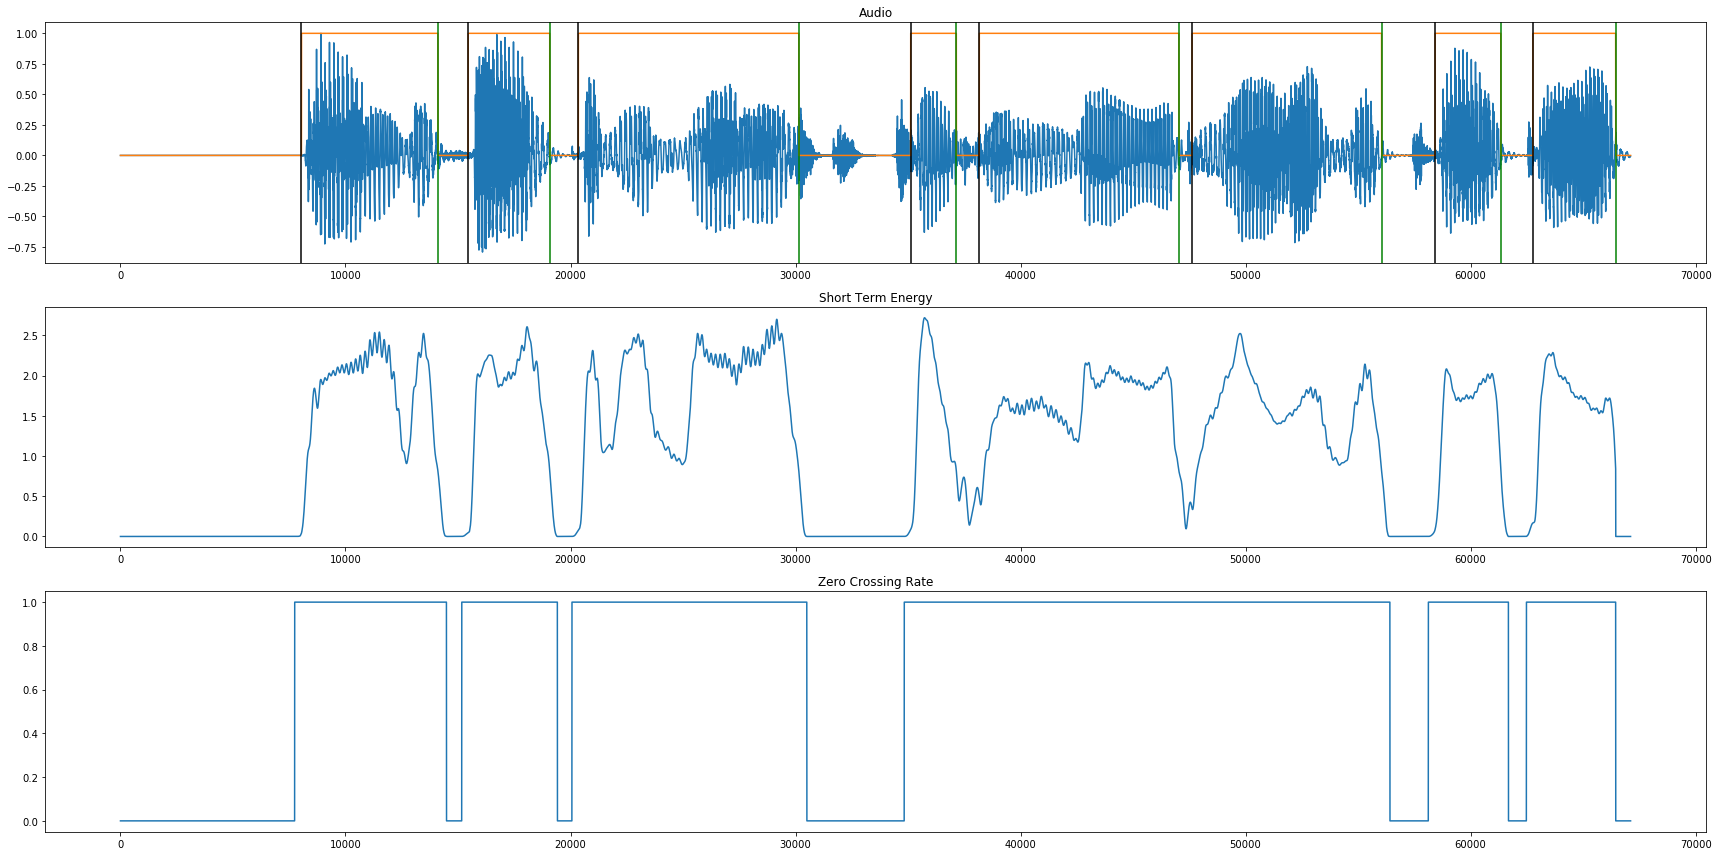

[ 0.  0.  0. ...,  0.  0.  0.]


In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
import peakutils
import IPython.display
import time
from scipy.signal import hamming, savgol_filter
from scipy.io import wavfile
from scipy import stats

# from listen.audio.segmentation import segments
from listen.spectrogram.spectrogram import Spectrogram
# from listen.data.librispeech import librispeech
from listen.data.an4 import an4

def get_segment_mask(data, mask, wsize, smooth=False, fuzz=0.2, alpha=0.95, energy=None, zxr=None, lowconf=True):
    N = len(data)
    zcr = np.zeros_like(data)
    ste = np.zeros_like(data)
    decision = np.zeros_like(data)
    xs = np.zeros_like(data, dtype=np.float32)
    ds = np.zeros_like(data, dtype=np.float32)
    window = hamming(wsize)
    data = data * mask
    if smooth:
        data = np.convolve(data, 8 * np.ones(wsize // 8) / wsize, mode='same')
    for i in range(N - 1):
        xs[i] = data[i].astype(np.float32) - alpha * data[i + 1].astype(np.float32)

    xs_ = np.r_[[0] * (wsize // 2) , data, [0] * (wsize // 2)]
    if energy is None:
        for i in range(wsize //2, N - wsize):
            ste[i - wsize // 2] = np.linalg.norm(xs_[i - wsize //2: i + wsize //2] * window, 2)
    else:
        ste = energy
    if zxr is None:
        for i in range(wsize // 2, N - wsize - 1):
            s = np.sign(xs_[i + 1 - wsize //2: i + wsize // 2 + 1]) - np.sign(xs_[i - wsize // 2: i + wsize // 2])
            np.clip(s, -1, 1, out=s)
            zcr[i - wsize //2] = np.max(np.abs(s))
    else:
        zcr = zxr
    thresh_ste = (fuzz * np.max(ste), (1 - fuzz) * np.max(ste))
    thresh_zcr = (fuzz * np.max(zcr), (1 - fuzz) * np.max(zcr))
    
    for i in range(1, N):
        if ste[i] > thresh_ste[0]:
            decision[i] = 1
        elif (ste[i] > thresh_ste[1] and ste[i] < thresh_ste[0]) and zcr[i] > thresh_zcr[1]:
            decision[i] = 1
        elif ste[i] < thresh_ste[0] and zcr[i] < thresh_zcr[0]:
            decision[i] = 0
        elif ste[i] < thresh_ste[0] and (zcr[i] < thresh_zcr[1] and zcr[i] > thresh_zcr[0]):
            if lowconf:
                decision[i] = 0.5
            else:
                decision[i] = 1
        elif ste[i] < thresh_ste[0] and zcr[i] > thresh_zcr[0]:
            decision[i] = 0

    for i in range(N - wsize//2):
        decision[i] = np.max(decision[i: i + wsize //2])
    
    return (decision, ste, zcr)

an4data = an4.AN4(conversion=False, debug=False)

# spg = Spectrogram(fft_size=2048, step_size=128, thresh=400)
train = list(an4data.trainset)
ch = random.choice(range(len(train)))
# ch = 179
# samples, t = train[ch]
samples = 'abk.wav'
# samples,t = librispeech.load_data(dev=True)[15]
# samples = 'D:\\theyenaman\\Dropbox\\code\\python\\ml_project\\listen\\data\\librispeech\\LibriSpeech\\dev-clean\\84\\121123\\84-121123-0020.wav'
rate, data = wavfile.read(samples)
c = np.random.randint(0, 100)
st =  c * (len(data) // 100)
en = (c + 1) * (len(data) // 100)
data = data[st:en]
# min_duration = int((1000 * len(data) / rate) / (20 * len(t) + 20))
min_duration = 20
wsize = (rate * min_duration) // 1000
if wsize % 2 == 1:
    wsize += 1

N = len(data)
alpha = 0.95
window = hamming(wsize)
print("Window: {} samples ({}ms)".format(wsize, min_duration))
print(st, en)
data = data / np.max(data)

start_time = time.time()
mask, ste, zcr = get_segment_mask(data, np.ones(len(data)), wsize, smooth=True)
mask, ste, zcr = get_segment_mask(data, np.ones(len(data)), wsize, smooth=True, energy=ste, zxr=zcr, lowconf=False)
mask, ste, zcr = get_segment_mask(data, mask, wsize, smooth=True, fuzz=0.7)
# mask, ste, zcr = get_segment_mask(data, mask, wsize, smooth=True)

zones = []
for i in range(len(mask) - 1):
    if mask[i] != mask[i+1]:
        zones.append(i)
silences = [(zones[i], zones[i + 1]) for i in range(len(zones) - 1) if mask[zones[i]] == 1 and mask[zones[i + 1]] == 0]
segments = [(zones[i], zones[i + 1]) for i in range(len(zones) - 1) if mask[zones[i]] == 0 and mask[zones[i + 1]] == 1]
end_time = time.time()
print("Time: {} x realtime".format((end_time - start_time) / ((en - st) / rate)))
print("Segments:", segments)
fig, ax = plt.subplots(nrows=3,ncols=1, figsize=(24, 12))
ax[0].plot(data)
ax[0].set_title('Audio')
ax[1].plot(ste)
ax[1].set_title('Short Term Energy')
ax[2].plot(zcr)
ax[2].set_title('Zero Crossing Rate')
ax[0].plot(mask)

for s in segments:
    ax[0].axvline(x=s[0], color='black')
    ax[0].axvline(x=s[1], color='green')
fig.tight_layout()
plt.show()
print(mask)
IPython.display.display(IPython.display.Audio(data=data, rate=rate))
# IPython.display.Audio(data=xs, rate=rate)